- Reference link: https://mp.weixin.qq.com/s/nU0_GrhWQv_gir--ZUBmOg
- Execution code: UESTC/Simple Test/Stable Diffusion

# Stable Diffusion模型原理

Stable Diffusion是一个**基于latent的扩散模型**，它在UNet中引入text condition来实现基于文本生成图像。Stable Diffusion的核心来源于**Latent Diffusion**这个工作，常规的扩散模型是基于pixel的生成模型，而Latent Diffusion是基于latent的生成模型，它先采用一个autoencoder将图像压缩到latent空间，然后用扩散模型来生成图像的latents，最后送入autoencoder的decoder模块就可以得到生成的图像。

<img src="https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyrlXJXO8fj9dedZPwbI5XuicTdIfdrdOAibJjRSQ8IPjmbM5cb3LicoeTKw/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1" style="zoom:50%;" />

**基于latent的扩散模型的优势在于计算效率更高效，因为图像的latent空间要比图像pixel空间要小，这也是Stable Diffusion的核心优势**。文生图模型往往参数量比较大，基于pixel的方法往往限于算力只生成64x64大小的图像，比如OpenAI的DALL-E2和谷歌的Imagen，然后再通过超分辨模型将图像分辨率提升至256x256和1024x1024；而基于latent的Stable Diffusion是在latent空间操作的，它可以直接生成256x256和512x512甚至更高分辨率的图像。

Stable Diffusion模型的主体结构如下图所示，主要包括三个模型：

- **autoencoder**：encoder将图像压缩到latent空间，而decoder将latent解码为图像；
- **CLIP text encoder**：提取输入text的text embeddings，通过cross attention方式送入扩散模型的UNet中作为condition；
- **UNet**：扩散模型的主体，用来实现文本引导下的latent生成。

<img src="https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyro2XZN6sZkDehfRcZCVxM2Xb7EeqUVwwvDpmUuyFNicUAtS9oU2y5FIg/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1" style="zoom:50%;" />

对于Stable Diffusion模型，其autoencoder模型参数大小为84M，CLIP text encoder模型大小为123M，而UNet参数大小为860M，所以**Stable Diffusion模型的总参数量约为1B**。

# autoencoder

autoencoder是一个基于encoder-decoder架构的图像压缩模型，对于一个大小为$H\times W \times 3$ 的输入图像，encoder模块将其编码为一个大小为 $h\times w \times c$ 的latent，其中 $f=\frac{H}{h}=\frac{W}{w}$ 为下采样率（downsampling factor）。在训练autoencoder过程中，除了采用**L1重建损失**外，还增加了**感知损失**（perceptual loss，即LPIPS，具体见论文The Unreasonable Effectiveness of Deep Features as a Perceptual Metric）以及**基于patch的对抗训练**。辅助loss主要是为了确保重建的图像局部真实性以及避免模糊，具体损失函数见latent diffusion的loss部分。同时为了防止得到的latent的标准差过大，采用了两种正则化方法：第一种是**KL-reg**，类似VAE增加一个latent和标准正态分布的KL loss，不过这里为了保证重建效果，采用比较小的权重（～10e-6）；第二种是**VQ-reg**，引入一个VQ （vector quantization）layer，此时的模型可以看成是一个VQ-GAN，不过VQ层是在decoder模块中，这里VQ的codebook采样较高的维度（8192）来降低正则化对重建效果的影响。 latent diffusion论文中实验了不同参数下的autoencoder模型，得出结论当 $f$ 较小和 $c$ 较大时，重建效果越好（PSNR越大），这也比较符合预期，毕竟此时压缩率小。

论文进一步将不同 $f$ 的autoencoder在扩散模型上进行实验，在ImageNet数据集上训练同样的步数（2M steps），得出结论过小的 $f$（比如1和2）下收敛速度慢，此时图像的感知压缩率较小，扩散模型需要较长的学习；而过大的 $f$ 其生成质量较差，此时压缩损失过大。

当 $f$ 在4～16时，可以取得相对好的效果。SD采用基于KL-reg的autoencoder，其中下采样率 $f=8$，特征维度为 $c=4$，当输入图像为512 x 512大小时将得到64 x 64 x 4大小的latent。 autoencoder模型时在OpenImages数据集上基于256 x 256大小训练的，但是由于autoencoder的模型是全卷积结构的（基于ResnetBlock），所以它可以扩展应用在尺寸>256的图像上。

In [ ]:
!pip install diffusers

In [ ]:
import os
path = "/content/drive/MyDrive/Simple Test"
os.chdir(path)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


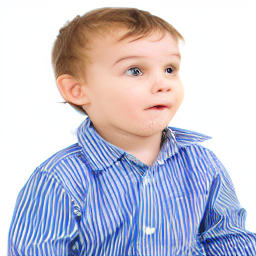

In [ ]:
# 使用diffusers库来加载autoencoder模型，并使用autoencoder来实现图像的压缩和重建
import torch
from diffusers import AutoencoderKL
import numpy as np
from PIL import Image

#加载模型: autoencoder可以通过SD权重指定subfolder来单独加载
autoencoder = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
autoencoder.to("cuda", dtype=torch.float16)

# 读取图像并预处理
raw_image = Image.open("boy.jpeg").convert("RGB").resize((256, 256))
image = np.array(raw_image).astype(np.float32) / 127.5 - 1.0
image = image[None].transpose(0, 3, 1, 2)
image = torch.from_numpy(image)

# 压缩图像为latent并重建
with torch.inference_mode():
    latent = autoencoder.encode(image.to("cuda", dtype=torch.float16)).latent_dist.sample()
    rec_image = autoencoder.decode(latent).sample
    rec_image = (rec_image / 2 + 0.5).clamp(0, 1)
    rec_image = rec_image.cpu().permute(0, 2, 3, 1).numpy()
    rec_image = (rec_image * 255).round().astype("uint8")
    rec_image = Image.fromarray(rec_image[0])
rec_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


通过实验对比可以看出，autoencoder将图片压缩到latent后再重建其实是有损的，比如会出现文字和人脸的畸变，在256 x 256分辨率下是比较明显的，512 x 512下效果会好很多。

这种有损压缩肯定是对SD的生成图像质量是有一定影响的，不过好在Stable Diffusion模型基本上是在512x512以上分辨率下使用的。为了改善这种畸变，stabilityai在发布Stable Diffusion 2.0时同时发布了两个在LAION子数据集上精调的autoencoder，注意这里只精调autoencoder的decoder部分，Stable Diffusion的UNet在训练过程只需要encoder部分，所以这样精调后的autoencoder可以直接用在先前训练好的UNet上（这种技巧还是比较通用的，比如谷歌的Parti也是在训练好后自回归生成模型后，扩大并精调ViT-VQGAN的decoder模块来提升生成质量）。

我们也可以直接在diffusers中使用这些autoencoder，比如mse版本（采用mse损失来finetune的模型），如下所示。
对于同样的图像，这个mse版本的重建效果相比原始版本的autoencoder，畸变是有一定改善的。

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


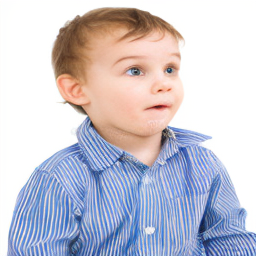

In [ ]:
import torch
from diffusers import AutoencoderKL
import numpy as np
from PIL import Image

autoencoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
autoencoder.to("cuda", dtype=torch.float16)

# 读取图像并预处理
raw_image = Image.open("boy.jpeg").convert("RGB").resize((256, 256))
image = np.array(raw_image).astype(np.float32) / 127.5 - 1.0
image = image[None].transpose(0, 3, 1, 2)
image = torch.from_numpy(image)

# 压缩图像为latent并重建
with torch.inference_mode():
    latent = autoencoder.encode(image.to("cuda", dtype=torch.float16)).latent_dist.sample()
    rec_image = autoencoder.decode(latent).sample
    rec_image = (rec_image / 2 + 0.5).clamp(0, 1)
    rec_image = rec_image.cpu().permute(0, 2, 3, 1).numpy()
    rec_image = (rec_image * 255).round().astype("uint8")
    rec_image = Image.fromarray(rec_image[0])
rec_image

由于Stable Diffusion采用的autoencoder是基于KL-reg的，所以这个autoencoder在编码图像时其实得到的是一个高斯分布DiagonalGaussianDistribution（分布的均值和标准差），然后通过调用sample方法来采样一个具体的latent（调用mode方法可以得到均值）。由于KL-reg的权重系数非常小，实际得到latent的标准差还是比较大的，latent diffusion论文中提出了一种rescaling方法：首先计算出第一个batch数据中的latent的标准差 $\hat{\sigma}$，然后采用 $\frac{1}{\hat{\sigma}}$ 的系数来rescale latent，这样就尽量保证latent的标准差接近1（防止扩散过程的SNR较高，影响生成效果，具体见latent diffusion论文的D1部分讨论），然后扩散模型也是应用在rescaling的latent上，在解码时只需要将生成的latent除以 $\frac{1}{\hat{\sigma}}$，然后再送入autoencoder的decoder即可。对于Stable Diffusion所使用的autoencoder，这个rescaling系数为0.18215。

# CLIP text encoder

Stable Diffusion**采用CLIP text encoder来对输入text提取text embeddings**，具体的是采用目前OpenAI所开源的最大CLIP模型：**clip-vit-large-patch14**，这个CLIP的text encoder是一个transformer模型（只有encoder模块）：层数为12，特征维度为768，模型参数大小是123M。对于输入text，送入CLIP text encoder后得到最后的hidden states（即最后一个transformer block得到的特征），其特征维度大小为77x768（77是token的数量），**这个细粒度的text embeddings将以cross attention的方式送入UNet中**。在transofmers库中，可以如下使用CLIP text encoder：

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder").to("cuda")
# text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# 对输入的text进行tokenize，得到对应的token ids
prompt = "a photograph of an astronaut riding a horse"
text_input_ids = text_tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
).input_ids

# 将token ids送入text model得到77x768的特征
text_embeddings = text_encoder(text_input_ids.to("cuda"))[0]

值得注意的是，这里的tokenizer最大长度为77（CLIP训练时所采用的设置），当输入text的tokens数量超过77后，将进行截断，如果不足则进行paddings，这样将保证无论输入任何长度的文本（甚至是空文本）都得到77x768大小的特征。 在训练SD的过程中，**CLIP text encoder模型是冻结的**。在早期的工作中，比如OpenAI的GLIDE和latent diffusion中的LDM均采用一个随机初始化的tranformer模型来提取text的特征，但是最新的工作都是采用预训练好的text model。比如谷歌的Imagen采用纯文本模型T5 encoder来提出文本特征，而SD则采用CLIP text encoder，预训练好的模型往往已经在大规模数据集上进行了训练，它们要比直接采用一个从零训练好的模型要好。

# UNet

Stable Diffusion的扩散模型是一个860M的UNet，其主要结构如下图所示（这里以输入的latent为64x64x4维度为例），其中encoder部分包括3个CrossAttnDownBlock2D模块和1个DownBlock2D模块，而decoder部分包括1个UpBlock2D模块和3个CrossAttnUpBlock2D模块，中间还有一个UNetMidBlock2DCrossAttn模块。encoder和decoder两个部分是完全对应的，中间存在skip connection。注意3个CrossAttnDownBlock2D模块最后均有一个2x的downsample操作，而DownBlock2D模块是不包含下采样的。

<img src="https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyrkqicpc0dUf330lb1Zf9V1FRSFed42ECTiaIIgWbKtX85XNaBabprSxQg/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1" style="zoom:50%;" />

其中CrossAttnDownBlock2D模块的主要结构如下图所示，text condition将通过CrossAttention模块嵌入进来，此时Attention的query是UNet的中间特征，而key和value则是text embeddings。

<img src="https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyrmE2h9XFRQIsnsKu9lK9VCbu7AxoYsIxdakkTMdELZ75Mf5RfKn45uA/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1" style="zoom:50%;" />

Stable Diffusion和DDPM一样采用预测noise的方法来训练UNet，其训练损失也和DDPM一样：这里的为text embeddings，此时的模型是一个条件扩散模型。基于diffusers库，我们可以很快实现SD的训练，其核心代码如下所示（这里参考diffusers库下examples中的finetune代码）：

In [ ]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch.nn.functional as F

# 加载autoencoder
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
# 加载text encoder
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
# 初始化UNet
unet = UNet2DConditionModel(**model_config) # model_config为模型参数配置
# 定义scheduler
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
)

# 冻结vae和text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

opt = torch.optim.AdamW(unet.parameters(), lr=1e-4)

for step, batch in enumerate(train_dataloader):
    with torch.no_grad():
        # 将image转到latent空间
        latents = vae.encode(batch["image"]).latent_dist.sample()
        latents = latents * vae.config.scaling_factor # rescaling latents
        # 提取text embeddings
        text_input_ids = text_tokenizer(
            batch["text"],
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
  ).input_ids
    text_embeddings = text_encoder(text_input_ids)[0]
    
    # 随机采样噪音
    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    # 随机采样timestep
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
    timesteps = timesteps.long()

    # 将noise添加到latent上，即扩散过程
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    # 预测noise并计算loss
    model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
    loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

opt.step()
opt.zero_grad()

In [ ]:
# 注意的是Stable Diffusion的noise scheduler虽然也是采用一个1000步长的scheduler，但是不是linear的，而是scaled linear，具体的计算如下所示：
betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2

在训练条件扩散模型时，往往会采用**Classifier-Free Guidance**（这里简称为CFG），所谓的CFG简单来说就是在训练条件扩散模型的同时也训练一个无条件的扩散模型，同时在采样阶段将条件控制下预测的噪音和无条件下的预测噪音组合在一起来确定最终的噪音，其中的 $w$ 为**guidance scale**，当 $w$ 越大时，condition起的作用越大，即生成的图像其更和输入文本一致。CFG的具体实现非常简单，在训练过程中，我们只需要**以一定的概率（比如10%）随机drop掉text**即可，这里我们可以将text置为空字符串（前面说过此时依然能够提取text embeddings）。这里并没有介绍CLF背后的技术原理，感兴趣的可以阅读CFG的论文Classifier-Free Diffusion Guidance以及guided diffusion的论文Diffusion Models Beat GANs on Image Synthesis。**CFG对于提升条件扩散模型的图像生成效果是至关重要的**。

# Stable Diffusion训练细节

Stable Diffusion是在laion2B-en数据集上训练的，它是laion-5b数据集的一个子集，更具体的说它是laion-5b中的英文（文本为英文）数据集。laion-5b数据集是从网页数据Common Crawl中筛选出来的图像-文本对数据集，它包含5.85B的图像-文本对，其中文本为英文的数据量为2.32B，其中图片的width和height均在256以上的样本量为1324M，在512以上的样本量为488M，而在1024以上的样本为76M；文本的平均长度为67。

laion数据集中除了图片（下载URL，图像width和height）和文本（描述文本）的元信息外，还包含以下信息：

- similarity：使用CLIP ViT-B/32计算出来的图像和文本余弦相似度；
- pwatermark：使用一个图片水印检测器检测的概率值，表示图片含有水印的概率；
- punsafe：图片是否安全，或者图片是不是NSFW，使用基于CLIP的检测器来估计；
- AESTHETIC_SCORE：图片的美学评分（1-10），这个是后来追加的，首先选择一小部分图片数据集让人对图片的美学打分，然后基于这个标注数据集来训练一个打分模型，并对所有样本计算估计的美学评分。

**Stable Diffusion的训练是多阶段的**（先在256x256尺寸上预训练，然后在512x512尺寸上精调），不同的阶段产生了不同的版本：

- Stable Diffusion v1.1：在laion2B-en数据集上以256x256大小训练237,000步，上面我们已经说了，laion2B-en数据集中256以上的样本量共1324M；然后在laion5B的高分辨率数据集以512x512尺寸训练194,000步，这里的高分辨率数据集是图像尺寸在1024x1024以上，共170M样本。
- Stable Diffusion v1.2：以Stable Diffusion v1.1为初始权重，在improved_aesthetics_5plus数据集上以512x512尺寸训练515,000步数，这个improved_aesthetics_5plus数据集上laion2B-en数据集中美学评分在5分以上的子集（共约600M样本），注意这里过滤了含有水印的图片（pwatermark>0.5)以及图片尺寸在512x512以下的样本。
- Stable Diffusion v1.3：以Stable Diffusion v1.2为初始权重，在improved_aesthetics_5plus数据集上继续以512x512尺寸训练195,000步数，不过这里采用了CFG（以10%的概率随机drop掉text）。
- Stable Diffusion v1.4：以Stable Diffusion v1.2为初始权重，在improved_aesthetics_5plus数据集上采用CFG以512x512尺寸训练225,000步数。
- Stable Diffusion v1.5：以Stable Diffusion v1.2为初始权重，在improved_aesthetics_5plus数据集上采用CFG以512x512尺寸训练595,000步数。

其实可以看到Stable Diffusion v1.3、Stable Diffusion v1.4和Stable Diffusion v1.5其实是以Stable Diffusion v1.2为起点在improved_aesthetics_5plus数据集上采用CFG训练过程中的不同checkpoints，**目前最常用的版本是Stable Diffusion v1.4和Stable Diffusion v1.5**。 Stable Diffusion的训练是**采用了32台8卡的A100机器**（32 x 8 x A100_40GB GPUs），所需要的训练硬件还是比较多的，但是相比语言大模型还好。单卡的训练batch size为2，并采用gradient accumulation，其中gradient accumulation steps=2，那么训练的**总batch size就是32x8x2x2=2048**。训练**优化器采用AdamW**，训练采用warmup，在初始10,000步后**学习速率升到0.0001**，后面保持不变。至于训练时间，文档上只说了用了150,000小时，这个应该是A100卡时，如果按照256卡A100来算的话，那么大约**需要训练25天左右**。

# 模型评测

对于文生图模型，目前常采用的定量指标是**FID**（Fréchet inception distance）和CLIP score，其中FID可以衡量生成图像的逼真度（image fidelity），而CLIP score评测的是生成的图像与输入文本的一致性，其中FID越低越好，而CLIP score是越大越好。当CFG的gudiance scale参数设置不同时，FID和CLIP score会发生变化。

由实验得出，当gudiance scale=3时，FID最低；而当gudiance scale越大时，CLIP score越大，但是FID同时也变大。在实际应用时，往往会采用较大的gudiance scale，比如SD模型默认采用7.5，此时生成的图像和文本有较好的一致性。从不同版本的对比曲线上看，Stable Diffusion的采用CFG训练后三个版本其实差别并没有那么大，其中Stable Diffusion v1.5相对好一点，但是明显要未采用CFG训练的版本要好的多，这说明CFG训练是比较关键的。 目前在模型对比上，大家往往是比较不同模型在COCO验证集上的zero-shot FID-30K（选择30K的样本），大家往往就选择模型所能得到的最小FID来比较，下面为eDiff和GigaGAN两篇论文所报道的不同文生图模型的FID对比（由于SD并没有给出FID-30K，所以大家应该都是自己用开源Stable Diffusion的模型计算的，由于选择样本不同，可能结果存在差异）：

<img src="https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyrXS041A9TlRcMd9l3zveIOrqmlQx7w9BThF0hsvLteKPAd2gGiaSpZ8w/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1" style="zoom: 67%;" />

可以看到Stable Diffusion虽然FID不是最好的，但是也能达到比较低的FID（大约在8～9之间）。不过虽然学术界常采用FID来定量比较模型，但是FID有很大的局限性，它并不能很好地衡量生成图像的质量，也是因为这个原因，谷歌的Imagen引入了人工评价，先建立一个评测数据集DrawBench（包含200个不同类型的text），然后用不同的模型来生成图像，让人去评价同一个text下不同模型生成的图像，这种评测方式比较直接，但是可能也受一些主观因素的影响。总而言之，目前的评价方式都有一定的局限性，最好还是直接上手使用来比较不同的模型。

# Stable Diffusion的主要应用

Stable Diffusion的主要应用包括**文生图**，**图生图**以及**图像inpainting**。其中文生图是Stable Diffusion的基础功能：根据输入文本生成相应的图像，而图生图和图像inpainting是在文生图的基础上延伸出来的两个功能。

## 文生图

根据文本生成图像这是文生图的最核心的功能，下图为Stable Diffusion的文生图的推理流程图：首先根据输入text用text encoder提取text embeddings，同时初始化一个随机噪音noise（latent上的，512x512图像对应的noise维度为64x64x4），然后将text embeddings和noise送入扩散模型UNet中生成去噪后的latent，最后送入autoencoder的decoder模块得到生成的图像。

<img src="https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyrd9Y5BKSIEKicnukObgHcwnv2aHHJficGKlACtN7HjvmnIg3Blk1M4l6Q/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1" style="zoom:67%;" />

使用diffusers库，我们可以直接调用`StableDiffusionPipeline`来实现文生图，具体代码如下所示：

In [ ]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm


model_id = "runwayml/stable-diffusion-v1-5"
# 1. 加载autoencoder
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
# 2. 加载tokenizer和text encoder 
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
# 3. 加载扩散模型UNet
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
# 4. 定义noise scheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False, # don't clip sample, the x0 in stable diffusion not in range [-1, 1]
    set_alpha_to_one=False,
)

# 将模型复制到GPU上
device = "cuda"
vae.to(device, dtype=torch.float16)
text_encoder.to(device, dtype=torch.float16)
unet = unet.to(device, dtype=torch.float16)

# 定义参数
prompt = [
    "A dragon fruit wearing karate belt in the snow",
    "A small cactus wearing a straw hat and neon sunglasses in the Sahara desert",
    "A photo of a raccoon wearing an astronaut helmet, looking out of the window at night",
    "A cute otter in a rainbow whirlpool holding shells, watercolor"
]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 7.5
negative_prompt = ""
batch_size = len(prompt)
# 随机种子
generator = torch.Generator(device).manual_seed(2023)


with torch.no_grad():
 # 获取text_embeddings
 text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
 text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
 # 获取unconditional text embeddings
 max_length = text_input.input_ids.shape[-1]
 uncond_input = tokenizer(
     [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
 )
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
 # 拼接为batch，方便并行计算
 text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

 # 生成latents的初始噪音
 latents = torch.randn(
     (batch_size, unet.in_channels, height // 8, width // 8),
     generator=generator, device=device
 )
 latents = latents.to(device, dtype=torch.float16)

 # 设置采样步数
 noise_scheduler.set_timesteps(num_inference_steps, device=device)

 # scale the initial noise by the standard deviation required by the scheduler
 latents = latents * noise_scheduler.init_noise_sigma # for DDIM, init_noise_sigma = 1.0

 timesteps_tensor = noise_scheduler.timesteps

 # Do denoise steps
 for t in tqdm(timesteps_tensor):
     # 这里latens扩展2份，是为了同时计算unconditional prediction
     latent_model_input = torch.cat([latents] * 2)
     latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t) # for DDIM, do nothing

     # 使用UNet预测噪音
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

     # 执行CFG
     noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
     noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

     # 计算上一步的noisy latents：x_t -> x_t-1
     latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
    
 # 注意要对latents进行scale
 latents = 1 / 0.18215 * latents
 # 使用vae解码得到图像
    image = vae.decode(latents).sample

## 图生图

**图生图（image2image）是对文生图功能的一个扩展**，这个功能来源于SDEdit这个工作，其核心思路也非常简单：给定一个笔画的色块图像，可以先给它加一定的高斯噪音（执行扩散过程）得到噪音图像，然后基于扩散模型对这个噪音图像进行去噪，就可以生成新的图像，但是这个图像在结构和布局和输入图像基本一致。

对于SD来说，图生图的流程图如下所示，相比文生图流程来说，这里的初始latent不再是一个随机噪音，而是由初始图像经过autoencoder编码之后的latent加高斯噪音得到，这里的加噪过程就是扩散过程。要注意的是，去噪过程的步数要和加噪过程的步数一致，就是说你加了多少噪音，就应该去掉多少噪音，这样才能生成想要的无噪音图像。

<img src="https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyrdO1JT6uWzl7mZiaodw7Cj3xng9iaZJQ0ibgTic1b4d8VIGQOIPLY5XXYsg/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1" style="zoom:67%;" />

在diffusers中，我们可以使用`StableDiffusionImg2ImgPipeline`来实现文生图，**图生图其实核心也是依赖了文生图的能力，其中strength这个参数需要灵活调节来得到满意的图像**，具体代码如下所示：

**图生图其实核心也是依赖了文生图的能力，其中strength这个参数需要灵活调节来得到满意的图像**。在最后，我们也给出图生图pipeline的内部主要代码，如下所示：

In [ ]:
import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image

# 加载图生图pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

# 读取初始图片
init_image = Image.open("init_image.png").convert("RGB")

# 推理
prompt = "A fantasy landscape, trending on artstation"
generator = torch.Generator(device="cuda").manual_seed(2023)

image = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.8,
    guidance_scale=7.5,
    generator=generator
).images[0]
image

In [ ]:
import PIL
import numpy as np
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm


model_id = "runwayml/stable-diffusion-v1-5"
# 1. 加载autoencoder
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
# 2. 加载tokenizer和text encoder 
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
# 3. 加载扩散模型UNet
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
# 4. 定义noise scheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False, # don't clip sample, the x0 in stable diffusion not in range [-1, 1]
    set_alpha_to_one=False,
)

# 将模型复制到GPU上
device = "cuda"
vae.to(device, dtype=torch.float16)
text_encoder.to(device, dtype=torch.float16)
unet = unet.to(device, dtype=torch.float16)

# 预处理init_image
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

# 参数设置
prompt = ["A fantasy landscape, trending on artstation"]
num_inference_steps = 50
guidance_scale = 7.5
strength = 0.8
batch_size = 1
negative_prompt = ""
generator = torch.Generator(device).manual_seed(2023)

init_image = PIL.Image.open("init_image.png").convert("RGB")

with torch.no_grad():
 # 获取prompt的text_embeddings
 text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
 text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
 # 获取unconditional text embeddings
 max_length = text_input.input_ids.shape[-1]
 uncond_input = tokenizer(
     [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
 )
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
# 拼接batch
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

 # 设置采样步数
 noise_scheduler.set_timesteps(num_inference_steps, device=device)
 # 根据strength计算timesteps
 init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
 t_start = max(num_inference_steps - init_timestep, 0)
 timesteps = noise_scheduler.timesteps[t_start:]


 # 预处理init_image
 init_input = preprocess(init_image)
    init_latents = vae.encode(init_input.to(device, dtype=torch.float16)).latent_dist.sample(generator)
    init_latents = 0.18215 * init_latents

 # 给init_latents加噪音
 noise = torch.randn(init_latents.shape, generator=generator, device=device, dtype=init_latents.dtype)
 init_latents = noise_scheduler.add_noise(init_latents, noise, timesteps[:1])
 latents = init_latents # 作为初始latents


 # Do denoise steps
 for t in tqdm(timesteps):
     # 这里latens扩展2份，是为了同时计算unconditional prediction
     latent_model_input = torch.cat([latents] * 2)
     latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t) # for DDIM, do nothing

     # 预测噪音
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

     # CFG
     noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
     noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

     # 计算上一步的noisy latents：x_t -> x_t-1
     latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
    
 # 注意要对latents进行scale
 latents = 1 / 0.18215 * latents
    # 解码
    image = vae.decode(latents).sample

## 图像inpainting

图像inpainting和图生图一样也是文生图功能的一个扩展。SD的图像inpainting不是用在图像修复上，而是主要用在**图像编辑**上：给定一个输入图像和想要编辑的区域mask，我们想通过文生图来编辑mask区域的内容。SD的图像inpainting原理可以参考论文Blended Latent Diffusion，其主要原理图如下所示：

![](https://mmbiz.qpic.cn/mmbiz_png/iaTa8ut6HiawCF5aXzQa1P0YicG7fTVyKyrHx4v9UXQZEeAR2WIKkloMdd9AOhcV0MOnsLuPP8ZqU3JE0VQ8TKwlA/640?wx_fmt=png&wxfrom=5&wx_lazy=1&wx_co=1)

它和图生图一样：首先将输入图像通过autoencoder编码为latent，然后加入一定的高斯噪音生成noisy latent，再进行去噪生成图像，但是这里为了保证mask以外的区域不发生变化，在去噪过程的每一步，都将扩散模型预测的noisy latent用真实图像同level的nosiy latent替换。 在diffusers中，使用`StableDiffusionInpaintPipelineLegacy`可以实现文本引导下的图像inpainting，具体代码如下所示：

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipelineLegacy
from PIL import Image

# 加载inpainting pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

# 读取输入图像和输入mask
input_image = Image.open("overture-creations-5sI6fQgYIuo.png").resize((512, 512))
input_mask = Image.open("overture-creations-5sI6fQgYIuo_mask.png").resize((512, 512))

# 执行推理
prompt = ["a mecha robot sitting on a bench", "a cat sitting on a bench"]
generator = torch.Generator("cuda").manual_seed(0)

with torch.autocast("cuda"):
    images = pipe(
        prompt=prompt,
        image=input_image,
        mask_image=input_mask,
        num_inference_steps=50,
        strength=0.75,
        guidance_scale=7.5,
        num_images_per_prompt=1,
        generator=generator,
    ).images

In [ ]:
# 给出StableDiffusionInpaintPipelineLegacy这个pipeline内部的核心代码

import PIL
import numpy as np
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm

def preprocess_mask(mask):
    mask = mask.convert("L")
    w, h = mask.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    mask = mask.resize((w // 8, h // 8), resample=PIL.Image.NEAREST)
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask, (4, 1, 1))
    mask = mask[None].transpose(0, 1, 2, 3)  # what does this step do?
    mask = 1 - mask  # repaint white, keep black
    mask = torch.from_numpy(mask)
    return mask

def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

model_id = "runwayml/stable-diffusion-v1-5"
# 1. 加载autoencoder
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
# 2. 加载tokenizer和text encoder 
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
# 3. 加载扩散模型UNet
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
# 4. 定义noise scheduler
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False, # don't clip sample, the x0 in stable diffusion not in range [-1, 1]
    set_alpha_to_one=False,
)

# 将模型复制到GPU上
device = "cuda"
vae.to(device, dtype=torch.float16)
text_encoder.to(device, dtype=torch.float16)
unet = unet.to(device, dtype=torch.float16)

prompt = "a mecha robot sitting on a bench"
strength = 0.75
guidance_scale = 7.5
batch_size = 1
num_inference_steps = 50
negative_prompt = ""
generator = torch.Generator(device).manual_seed(0)

with torch.no_grad():
    # 获取prompt的text_embeddings
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
    # 获取unconditional text embeddings
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [negative_prompt] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
    # 拼接batch
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # 设置采样步数
    noise_scheduler.set_timesteps(num_inference_steps, device=device)
    # 根据strength计算timesteps
    init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
    t_start = max(num_inference_steps - init_timestep, 0)
    timesteps = noise_scheduler.timesteps[t_start:]


    # 预处理init_image
    init_input = preprocess(input_image)
    init_latents = vae.encode(init_input.to(device, dtype=torch.float16)).latent_dist.sample(generator)
    init_latents = 0.18215 * init_latents
    init_latents = torch.cat([init_latents] * batch_size, dim=0)
    init_latents_orig = init_latents
    # 处理mask
    mask_image = preprocess_mask(input_mask)
    mask_image = mask_image.to(device=device, dtype=init_latents.dtype)
    mask = torch.cat([mask_image] * batch_size)
    
    # 给init_latents加噪音
    noise = torch.randn(init_latents.shape, generator=generator, device=device, dtype=init_latents.dtype)
    init_latents = noise_scheduler.add_noise(init_latents, noise, timesteps[:1])
    latents = init_latents # 作为初始latents


    # Do denoise steps
    for t in tqdm(timesteps):
        # 这里latens扩展2份，是为了同时计算unconditional prediction
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, t) # for DDIM, do nothing

        # 预测噪音
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # 计算上一步的noisy latents：x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample
        
        # 将unmask区域替换原始图像的nosiy latents
        init_latents_proper = noise_scheduler.add_noise(init_latents_orig, noise, torch.tensor([t]))
        latents = (init_latents_proper * mask) + (latents * (1 - mask))

    # 注意要对latents进行scale
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample



另外，runwayml在发布SD 1.5版本的同时还发布了一个inpainting模型：runwayml/stable-diffusion-inpainting，与前面所讲不同的是，这是一个**在SD 1.2上finetune的模型**。原来SD的UNet的输入是64x64x4，为了实现inpainting，现在给UNet的第一个卷机层增加5个channels，分别为masked图像的latents（经过autoencoder编码，64x64x4）和mask图像（直接下采样8x，64x64x1），增加的权重填零初始化。在diffusers中，可以使用`StableDiffusionInpaintPipeline`来调用这个模型，具体代码如下：

In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image
from tqdm.auto import tqdm
import PIL

# Load pipeline
model_id = "runwayml/stable-diffusion-inpainting/"
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

prompt = ["a mecha robot sitting on a bench", "a dog sitting on a bench", "a bench"]

generator = torch.Generator("cuda").manual_seed(2023)

input_image = Image.open("overture-creations-5sI6fQgYIuo.png").resize((512, 512))
input_mask = Image.open("overture-creations-5sI6fQgYIuo_mask.png").resize((512, 512))

images = pipe(
    prompt=prompt,
    image=input_image,
    mask_image=input_mask,
    num_inference_steps=50,
    generator=generator,
    ).images